In [3]:
import sys
import os

# Agregar el directorio raíz del proyecto a sys.path
project_root = "/home/javitrucas/TFG"
if project_root not in sys.path:
    sys.path.append(project_root)

# Cell 1: Imports and setup
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from scripts.MNIST.MNISTMILDataset import MNISTMILDataset
from scripts.MNIST.MNISTmodel import MILModel

# Reproducibilidad
torch.manual_seed(42)

# Hyperparámetros
target_digit = 3       # Dígito objetivo para las bolsas
bag_size = 10          # Número de instancias por bolsa
num_epochs = 10        # Número de épocas
a_learning_rate = 1e-3  # Tasa de aprendizaje
batch_size = 1         # Tamaño de lote
pooling_type = 'mean'  # 'attention', 'mean' o 'max'

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Cell 2: Dataset y DataLoaders
full_train_dataset = MNISTMILDataset(subset='train', bag_size=bag_size, obj_label=target_digit)
test_dataset = MNISTMILDataset(subset='test', bag_size=bag_size, obj_label=target_digit)

# División train/validation
total_train = len(full_train_dataset)
val_size = int(0.2 * total_train)
train_size = total_train - val_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# DataLoaders
dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=batch_size)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size)

# Cell 3: Modelo, criterio y optimizador
model = MILModel(pooling_type=pooling_type).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=a_learning_rate)

# Cell 4: Loop de entrenamiento
def train():
    model.train()
    for epoch in range(1, num_epochs+1):
        total_loss = 0.0
        for bag, bag_label, inst_labels, lap in dataloader_train:
            bag = bag.to(device)
            bag_label = bag_label.to(device)

            optimizer.zero_grad()
            output, attn = model(bag)
            loss = criterion(output.squeeze(-1), bag_label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader_train)
        print(f"Época {epoch}/{num_epochs} - Loss: {avg_loss:.4f}")

train()

# Cell 5: Evaluación en test set
model.eval()
all_outputs, all_labels = [], []
with torch.no_grad():
    for bag, bag_label, inst_labels, lap in dataloader_test:
        bag = bag.to(device)
        bag_label = bag_label.to(device)
        output, attn = model(bag)
        all_outputs.append(output.cpu())
        all_labels.append(bag_label.cpu())

# Métricas
torch_outputs = torch.cat(all_outputs).squeeze()
torch_labels = torch.cat(all_labels)
accuracy = ((torch_outputs > 0.5).float() == torch_labels).float().mean()
print(f"Accuracy en test: {accuracy:.4f}")

# Visualización de pesos de atención (si aplica)
if pooling_type == 'attention':
    import matplotlib.pyplot as plt
    bag, _, _, _ = next(iter(dataloader_test))
    _, attn_weights = model(bag.to(device))
    attn_weights = attn_weights.cpu().numpy()[0]
    plt.bar(range(len(attn_weights)), attn_weights)
    plt.title('Pesos de atención para una bolsa de prueba')
    plt.show()


/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Usando dispositivo: cuda


KeyboardInterrupt: 

Usando dispositivo: cuda
Época 1/10 - Train Loss: 0.2378, Val Loss: 0.1065, Val Acc: 0.9658
Época 2/10 - Train Loss: 0.0846, Val Loss: 0.0663, Val Acc: 0.9783


RuntimeError: a Tensor with 10 elements cannot be converted to Scalar

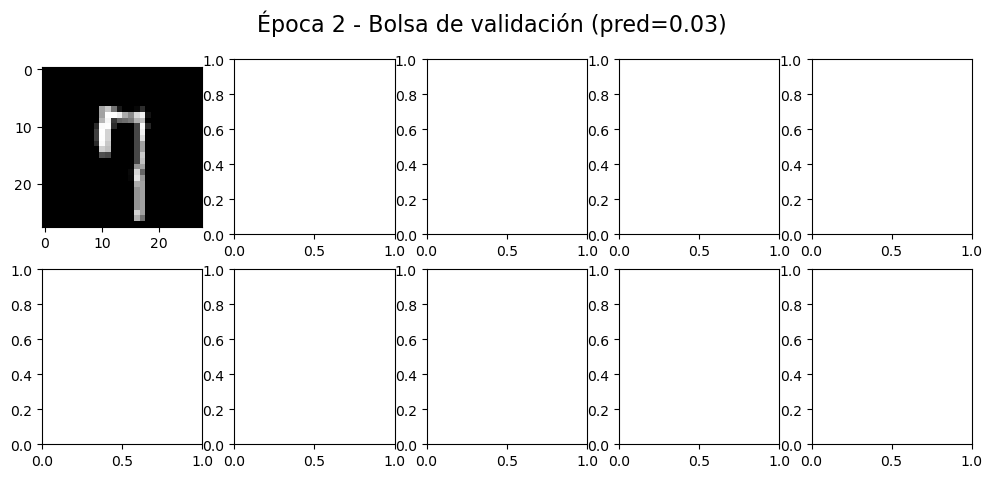

In [4]:
import sys
import os

# Agregar el directorio raíz del proyecto a sys.path
project_root = "/home/javitrucas/TFG"
if project_root not in sys.path:
    sys.path.append(project_root)

# Cell 1: Imports and setup
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from scripts.MNIST.MNISTMILDataset import MNISTMILDataset
from scripts.MNIST.MNISTmodel import MILModel
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from matplotlib.colors import LinearSegmentedColormap

# Reproducibilidad
torch.manual_seed(42)

# Hyperparámetros
target_digit = 3       # Dígito objetivo para las bolsas
bag_size = 10          # Número de instancias por bolsa
num_epochs = 10        # Número de épocas
a_learning_rate = 1e-3  # Tasa de aprendizaje
batch_size = 1         # Tamaño de lote
pooling_type = 'attention'  # 'attention', 'mean' o 'max'

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Cell 2: Dataset y DataLoaders
full_train_dataset = MNISTMILDataset(subset='train', bag_size=bag_size, obj_label=target_digit)
test_dataset = MNISTMILDataset(subset='test', bag_size=bag_size, obj_label=target_digit)

# División train/validation
total_train = len(full_train_dataset)
val_size = int(0.2 * total_train)
train_size = total_train - val_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# DataLoaders
dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=batch_size)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size)

# Cell 3: Modelo, criterio y optimizador
model = MILModel(pooling_type=pooling_type).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=a_learning_rate)

# Función para visualizar una bolsa y sus etiquetas
def visualize_bag(bag, bag_label, inst_labels, lap=None, attn_weights=None, title=None, save_path=None):
    """
    Visualiza una bolsa de instancias MNIST con sus etiquetas y opcionalmente los pesos de atención.
    
    Args:
        bag: Tensor con las imágenes (batch_size, bag_size, 1, 28, 28)
        bag_label: Etiqueta de la bolsa (positiva o negativa)
        inst_labels: Etiquetas de cada instancia
        lap: Indices de los dígitos originales (para referencia)
        attn_weights: Opcional, pesos de atención por instancia
        title: Opcional, título para la visualización
        save_path: Opcional, ruta para guardar la imagen
    """
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    axes = axes.flatten()
    
    bag = bag.squeeze(0)  # Eliminar dimensión de batch
    inst_labels = inst_labels.squeeze(0).numpy()
    
    # Título principal
    if title is None:
        title = f"Bolsa {'POSITIVA' if bag_label.item() > 0.5 else 'NEGATIVA'} - Dígito objetivo: {target_digit}"
    plt.suptitle(title, fontsize=16)
    
    # Visualizar cada instancia
    for i in range(bag_size):
        img = bag[i].squeeze().cpu().numpy()
        ax = axes[i]
        im = ax.imshow(img, cmap='gray')
        
        border_color = 'red' if inst_labels[i] == 1 else 'blue'
        ax.set_title(f"{lap[0][i].item()}", color=border_color)
        
        # Si hay pesos de atención, mostrarlos en el título
        if attn_weights is not None:
            ax.set_xlabel(f"Attn: {attn_weights[i]:.3f}", fontsize=8)
            # Añadir un borde coloreado según el peso de atención
            for spine in ax.spines.values():
                spine.set_linewidth(2)
                # Color más intenso para mayores pesos de atención
                intensity = min(1.0, attn_weights[i] * 3)
                spine.set_edgecolor((1.0, 0.0, 0.0, intensity))
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

# Función para visualizar un mapa de calor basado en atención
def visualize_attention_heatmap(bag, attn_weights, bag_label, prediction, save_path=None):
    """
    Genera un mapa de calor superpuesto para visualizar la atención sobre una bolsa.
    
    Args:
        bag: Tensor con las imágenes (bag_size, 1, 28, 28)
        attn_weights: Pesos de atención normalizados
        bag_label: Etiqueta real de la bolsa
        prediction: Predicción del modelo para la bolsa
        save_path: Opcional, ruta para guardar la imagen
    """
    # Crear un grid para todas las instancias
    bag = bag.squeeze(0)  # Eliminar dimensión de batch
    grid_size = int(np.ceil(np.sqrt(bag_size)))
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Crear una imagen compuesta con todas las instancias
    composite_img = np.zeros((grid_size * 28, grid_size * 28))
    attn_map = np.zeros((grid_size * 28, grid_size * 28))
    
    for i in range(bag_size):
        row = i // grid_size
        col = i % grid_size
        img = bag[i].squeeze().cpu().numpy()
        composite_img[row*28:(row+1)*28, col*28:(col+1)*28] = img
        attn_map[row*28:(row+1)*28, col*28:(col+1)*28] = attn_weights[i]
    
    # Visualizar la imagen base
    ax.imshow(composite_img, cmap='gray', alpha=1.0)
    
    # Superponer mapa de calor de atención
    cmap = LinearSegmentedColormap.from_list('custom_cmap', ['blue', 'yellow', 'red'])
    heat = ax.imshow(attn_map, cmap=cmap, alpha=0.5)
    
    # Añadir barra de color
    cbar = plt.colorbar(heat, ax=ax)
    cbar.set_label('Peso de atención')
    
    # Título
    correct = (bag_label.item() > 0.5) == (prediction > 0.5)
    title = f"Predicción {'correcta' if correct else 'incorrecta'}: {prediction:.2f}, Real: {bag_label.item()}"
    ax.set_title(title)
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

# Cell 4: Loop de entrenamiento con visualización
def train():
    model.train()
    train_losses = []
    val_losses = []
    
    for epoch in range(1, num_epochs+1):
        # Entrenamiento
        model.train()
        total_loss = 0.0
        for bag, bag_label, inst_labels, lap in dataloader_train:
            bag = bag.to(device)
            bag_label = bag_label.to(device)
            
            optimizer.zero_grad()
            output, attn = model(bag)
            loss = criterion(output.squeeze(-1), bag_label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_train_loss = total_loss / len(dataloader_train)
        train_losses.append(avg_train_loss)
        
        # Validación
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for bag, bag_label, inst_labels, lap in dataloader_val:
                bag = bag.to(device)
                bag_label = bag_label.to(device)
                output, attn = model(bag)
                loss = criterion(output.squeeze(-1), bag_label)
                val_loss += loss.item()
                
                pred = (output.squeeze(-1) > 0.5).float()
                correct += (pred == bag_label).sum().item()
                total += bag_label.size(0)
        
        avg_val_loss = val_loss / len(dataloader_val)
        val_acc = correct / total
        val_losses.append(avg_val_loss)
        
        print(f"Época {epoch}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Visualizar una bolsa de validación cada 2 épocas
        if epoch % 2 == 0:
            model.eval()
            with torch.no_grad():
                # Obtener una muestra de validación
                val_bag, val_label, val_inst_labels, val_lap = next(iter(dataloader_val))
                val_bag = val_bag.to(device)
                val_pred, val_attn = model(val_bag)
                val_attn = val_attn.cpu().numpy()[0]
                
                # Visualizar la bolsa con pesos de atención
                visualize_bag(
                    val_bag.cpu(), 
                    val_label, 
                    val_inst_labels, 
                    val_lap,
                    val_attn, 
                    title=f"Época {epoch} - Bolsa de validación (pred={val_pred.item():.2f})"
                )
    
    # Visualizar curvas de pérdida
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.title('Curvas de pérdida durante el entrenamiento')
    plt.legend()
    plt.grid(True)
    plt.show()

# Entrenar el modelo
train()

# Cell 5: Evaluación en test set con visualizaciones
model.eval()
all_outputs = []
all_labels = []
all_attentions = []
all_bags = []
all_inst_labels = []
all_laps = []

with torch.no_grad():
    for bag, bag_label, inst_labels, lap in dataloader_test:
        bag = bag.to(device)
        bag_label = bag_label.to(device)
        output, attn = model(bag)
        
        all_outputs.append(output.cpu())
        all_labels.append(bag_label.cpu())
        if pooling_type == 'attention':
            all_attentions.append(attn.cpu())
        
        # Guardar las bolsas y etiquetas para visualizaciones
        all_bags.append(bag.cpu())
        all_inst_labels.append(inst_labels)
        all_laps.append(lap)

# Convertir listas a tensores
torch_outputs = torch.cat(all_outputs).squeeze()
torch_labels = torch.cat(all_labels)
torch_preds = (torch_outputs > 0.5).float()

# Métricas
accuracy = (torch_preds == torch_labels).float().mean()
print(f"Accuracy en test: {accuracy:.4f}")

# Matriz de confusión
cm = confusion_matrix(torch_labels.numpy(), torch_preds.numpy())
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negativo', 'Positivo'], 
            yticklabels=['Negativo', 'Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(torch_labels.numpy(), torch_outputs.numpy())
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Visualización de casos correctos e incorrectos
correct_indices = (torch_preds == torch_labels).nonzero().squeeze().numpy()
incorrect_indices = (torch_preds != torch_labels).nonzero().squeeze().numpy()

# Asegurarse de que los índices sean iterables incluso si solo hay uno
if not hasattr(correct_indices, "__len__"):
    correct_indices = [correct_indices]
if not hasattr(incorrect_indices, "__len__"):
    incorrect_indices = [incorrect_indices]

print(f"Predicciones correctas: {len(correct_indices)}")
print(f"Predicciones incorrectas: {len(incorrect_indices)}")

# Visualizar casos correctos
if len(correct_indices) > 0:
    # Seleccionar hasta 3 casos correctos aleatorios
    samples = np.random.choice(correct_indices, size=min(3, len(correct_indices)), replace=False)
    for idx in samples:
        bag = all_bags[idx]
        bag_label = torch_labels[idx]
        inst_labels = all_inst_labels[idx]
        lap = all_laps[idx]
        prediction = torch_outputs[idx].item()
        
        # Visualizar la bolsa
        visualize_bag(
            bag, 
            bag_label, 
            inst_labels, 
            lap,
            all_attentions[idx][0].numpy() if pooling_type == 'attention' else None,
            title=f"Predicción CORRECTA: {prediction:.2f}, Real: {bag_label.item()}"
        )
        
        # Visualizar mapa de calor si estamos usando atención
        if pooling_type == 'attention':
            visualize_attention_heatmap(
                bag,
                all_attentions[idx][0].numpy(),
                bag_label,
                prediction
            )

# Visualizar casos incorrectos
if len(incorrect_indices) > 0:
    # Seleccionar hasta 3 casos incorrectos aleatorios
    samples = np.random.choice(incorrect_indices, size=min(3, len(incorrect_indices)), replace=False)
    for idx in samples:
        bag = all_bags[idx]
        bag_label = torch_labels[idx]
        inst_labels = all_inst_labels[idx]
        lap = all_laps[idx]
        prediction = torch_outputs[idx].item()
        
        # Visualizar la bolsa
        visualize_bag(
            bag, 
            bag_label, 
            inst_labels, 
            lap,
            all_attentions[idx][0].numpy() if pooling_type == 'attention' else None,
            title=f"Predicción INCORRECTA: {prediction:.2f}, Real: {bag_label.item()}"
        )
        
        # Visualizar mapa de calor si estamos usando atención
        if pooling_type == 'attention':
            visualize_attention_heatmap(
                bag,
                all_attentions[idx][0].numpy(),
                bag_label,
                prediction
            )

# Análisis de atención (específico para pooling de atención)
if pooling_type == 'attention':
    # Calcular correlación entre atención y presencia del dígito objetivo
    print("\nAnálisis de atención:")
    
    # Recopilar datos para análisis
    attn_on_target = []
    attn_on_nontarget = []
    
    for idx in range(len(all_bags)):
        bag_attn = all_attentions[idx][0].numpy()
        inst_labels = all_inst_labels[idx].squeeze().numpy()
        
        for i in range(bag_size):
            if inst_labels[i] == 1:  # Instancia con dígito objetivo
                attn_on_target.append(bag_attn[i])
            else:  # Instancia sin dígito objetivo
                attn_on_nontarget.append(bag_attn[i])
    
    # Convertir a arrays de numpy
    attn_on_target = np.array(attn_on_target)
    attn_on_nontarget = np.array(attn_on_nontarget)
    
    # Estadísticas descriptivas
    print(f"Atención media en instancias con dígito {target_digit}: {attn_on_target.mean():.4f} ± {attn_on_target.std():.4f}")
    print(f"Atención media en instancias sin dígito {target_digit}: {attn_on_nontarget.mean():.4f} ± {attn_on_nontarget.std():.4f}")
    
    # Visualizar distribución de atención
    plt.figure(figsize=(10, 6))
    sns.histplot(attn_on_target, color='red', alpha=0.5, label=f'Dígito {target_digit}', kde=True)
    sns.histplot(attn_on_nontarget, color='blue', alpha=0.5, label='Otros dígitos', kde=True)
    plt.xlabel('Peso de atención')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de pesos de atención por tipo de instancia')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualización de pesos de atención (independiente del tipo de pooling)
# Obtenemos una bolsa específica para analizar
sample_idx = 0  # Podemos cambiar este índice según interés
bag, bag_label, inst_labels, lap = (
    all_bags[sample_idx], 
    torch_labels[sample_idx], 
    all_inst_labels[sample_idx], 
    all_laps[sample_idx]
)

# Para pooling de atención, visualizamos los pesos de atención
if pooling_type == 'attention':
    attn_weights = all_attentions[sample_idx][0].numpy()
    
    # Visualizar pesos de atención como barras
    plt.figure(figsize=(12, 5))
    bars = plt.bar(range(len(attn_weights)), attn_weights)
    plt.xlabel('Índice de instancia')
    plt.ylabel('Peso de atención')
    plt.title('Pesos de atención para una bolsa de prueba')
    
    # Colorear las barras según si contienen el dígito objetivo
    inst_labels_np = inst_labels.squeeze().numpy()
    for i, bar in enumerate(bars):
        bar.set_color('red' if inst_labels_np[i] == 1 else 'blue')
    
    # Añadir leyenda
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red', label=f'Dígito {target_digit}'),
        Patch(facecolor='blue', label='Otros dígitos')
    ]
    plt.legend(handles=legend_elements)
    
    plt.grid(True)
    plt.show()
    
    # Obtener la bolsa completa para visualizar junto con la atención
    visualize_bag(
        bag, 
        bag_label, 
        inst_labels, 
        lap,
        attn_weights,
        title=f"Análisis de atención - Dígito objetivo: {target_digit}"
    )

# Para cualquier tipo de pooling, visualizamos la bolsa y su predicción
else:
    with torch.no_grad():
        bag_tensor = bag.to(device)
        output, _ = model(bag_tensor)
        prediction = output.cpu().item()
    
    visualize_bag(
        bag, 
        bag_label, 
        inst_labels, 
        lap,
        title=f"Predicción: {prediction:.2f} - Tipo de pooling: {pooling_type}"
    )

# Comparación de métodos de pooling (si hay interés en comparar)
def compare_pooling_methods():
    """
    Comparar diferentes métodos de pooling en la misma bolsa.
    """
    # Guardar los pesos originales del modelo con pooling actual
    original_state_dict = model.state_dict()
    
    # Seleccionar una bolsa para análisis
    bag, bag_label, inst_labels, lap = next(iter(dataloader_test))
    
    results = {}
    pooling_types = ['max', 'mean', 'attention']
    
    for pool_type in pooling_types:
        # Crear un modelo con el tipo de pooling específico
        temp_model = MILModel(pooling_type=pool_type).to(device)
        
        # Si es el mismo tipo de pooling que el original, usar los pesos entrenados
        if pool_type == pooling_type:
            temp_model.load_state_dict(original_state_dict)
        
        # Evaluar
        temp_model.eval()
        with torch.no_grad():
            bag_tensor = bag.to(device)
            output, attn = temp_model(bag_tensor)
            prediction = output.cpu().item()
        
        results[pool_type] = {
            'prediction': prediction,
            'attention': attn.cpu().numpy()[0] if pool_type == 'attention' else None
        }
    
    # Visualizar resultados
    plt.figure(figsize=(12, 4))
    for i, pool_type in enumerate(pooling_types):
        plt.subplot(1, 3, i+1)
        plt.title(f"Pooling: {pool_type}\nPred: {results[pool_type]['prediction']:.2f}")
        
        # La bolsa es la misma, solo mostramos una imagen representativa
        representative_idx = 0
        img = bag[0, representative_idx, 0].numpy()
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle(f"Comparación de métodos de pooling - Etiqueta real: {bag_label.item()}")
    plt.subplots_adjust(top=0.8)
    plt.show()
    
    # Restaurar el modelo original
    model.load_state_dict(original_state_dict)

# Ejecutar comparación de pooling si se desea
compare_pooling_methods()